In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Decoder,self).__init__()
        self.relu  = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=out_channels*2, 
                               kernel_size=3, stride=1, 
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels*2, 
                               out_channels=out_channels, 
                               kernel_size=3, stride=1, 
                               padding=1)
        self.up  = F.interpolate
    def forward(self, x):
        x = self.up(x, scale_factor=2 ,mode='bilinear', align_corners=False)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Encoder,self).__init__()
        self.relu = nn.ReLU()
        mid_channels = int((out_channels-in_channels)/2.0)+in_channels
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=mid_channels, 
                               kernel_size=3, stride=1, 
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=out_channels, 
                               kernel_size=3, stride=1, 
                               padding=1)
        self.pool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    def forward(self,x):
        conv1 = self.conv1(x)
        act_conv1 = self.relu(conv1)
        conv2 = self.conv2(act_conv1)
        act_conv2 = self.relu(conv2)
        pool = self.pool(act_conv2)
        return pool

    
# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.enc1 = Encoder(1,32)
#         self.enc2 = Encoder(32,64)
#         self.enc3 = Encoder(64,128)
#         self.mid = nn.Conv2d(128, 64, 1, stride=1, padding=0)
#         self.relu = nn.ReLU()
#         self.dec1 = Decoder(192,64)
#         self.dec2 = Decoder(128,32)
#         self.dec3 = Decoder(64,1)
                                      

#     def forward(self,x):
#         # x is of size: 15x55x5 -double up-> 30x110x5
#         # enc1: # size 30x110x5 -> 15x55x32
#         # enc2: # size 15x55x32 -> 8x28x64
#         # enc3: # size 8x28x64 -> 4x14x128
#         # mid: # size 4x14x128 -> 4x14x64
#         # dec1: # mid + enc3: size 4x14x192 -> 8x28x64
#         # dec2: # dec1 + enc2: size 8x28x128 -> 16x56x32
#         # dec3: # dec2 + enc1: size 16x56x64 -> 32x112x5
#         enc1 = self.enc1(x)
#         enc2 = self.enc2(enc1)
#         enc3 = self.enc3(enc2)
#         mid = self.mid(enc3)
#         act_mid = self.relu(mid)
#         dec1 = self.dec1(torch.cat([act_mid, enc3], 1))
#         dec2 = self.dec2(torch.cat([dec1, enc2], 1))
#         dec3 = self.dec3(torch.cat([dec2[:,:,0:15,0:55], enc1], 1))
#         return dec3

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = Encoder(1,32)
        self.enc2 = Encoder(32,64)
        self.mid = nn.Conv2d(64, 32, 1, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.dec2 = Decoder(96,32)
        self.dec3 = Decoder(64,1)
                                      

    def forward(self,x):
        # x is of size: 15x55x5 -double up-> 30x110x5
        # enc1: # size 30x110x5 -> 15x55x32
        # enc2: # size 15x55x32 -> 8x28x64
        # mid: # size 8x28x64 -> 8x28x32
        # dec2: # dec1 + enc2: size 8x28x(32+64) -> 16x56x32
        # dec3: # dec2 + enc1: size 16x56x64 -> 32x112x5
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        mid = self.mid(enc2)
        act_mid = self.relu(mid)
        dec2 = self.dec2(torch.cat([act_mid, enc2], 1))
        dec3 = self.dec3(torch.cat([dec2[:,:,0:15,0:55], enc1], 1))
        return dec3

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.enc1 = Encoder(1,32)
#         self.mid = nn.Conv2d(32, 16, 1, stride=1, padding=0)
#         self.relu = nn.ReLU()
#         self.dec3 = Decoder(48,1)


#     def forward(self,x):
#         # x is of size: 15x55x5 -double up-> 30x110x5
#         # enc1: # size 30x110x5 -> 15x55x32
#         # mid: # size 15x55x32 -> 15x55x16
#         # dec3: # dec2 + enc1: size 15x55x48 -> 32x112x5
#         enc1 = self.enc1(x)
#         mid = self.mid(enc1)
#         act_mid = self.relu(mid)
#         dec3 = self.dec3(torch.cat([act_mid, enc1], 1))
#         return dec3

In [3]:
batch_size = 4
device='cuda'
array_X = np.load('data_X_2.npy')
array_Y = np.load('data_Y_2.npy')
N=array_X.shape[0]

diff = np.max(np.reshape(array_Y[:,:,:,:],(N,-1)),axis=1)-np.min(np.reshape(array_Y[:,:,:,:],(N,-1)),axis=1)
mask = diff>0.1

array_Y = array_Y[mask,:,:,:]
array_X = array_X[mask,:,:,:]

N=array_X.shape[0]

array_X = np.moveaxis(array_X, -1, 1)
array_Y = np.moveaxis(array_Y, -1, 1)

array_X = np.reshape(array_X, (N*5,1,array_X.shape[2],array_X.shape[3]))
array_Y = np.reshape(array_Y, (N*5,1,array_Y.shape[2],array_Y.shape[3]))
N=array_X.shape[0]

#array_X = np.repeat(array_X, 2, axis=2).repeat(2, axis=3)
print(array_X.shape, array_Y.shape)

test_indices = list(np.random.choice(range(N), size=int(N * 0.15), replace=False))
train_indices = [item for item in range(N) if item not in test_indices]

train_array_X = array_X[train_indices,:,:,:]
test_array_X = array_X[test_indices,:,:,:]

train_array_Y = array_Y[train_indices,:,:,:]
test_array_Y = array_Y[test_indices,:,:,:]


# pt_train_array_X = Variable(torch.from_numpy(train_array_X).float(), requires_grad=False).to(device)
# pt_train_array_Y = Variable(torch.from_numpy(train_array_Y).float(), requires_grad=False).to(device)

pt_test_array_X = Variable(torch.from_numpy(test_array_X).float(), requires_grad=False).to(device)
pt_test_array_Y = Variable(torch.from_numpy(test_array_Y).float(), requires_grad=False).to(device)

tensor_x = torch.Tensor(train_array_X).to(device)
tensor_y = torch.Tensor(train_array_Y).to(device)
dataset = TensorDataset(tensor_x,tensor_y) # create your datset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

(17585, 1, 15, 55) (17585, 1, 30, 110)


In [4]:
### (2) Model
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Conv2D') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 5.0)
        m.bias.data.fill_(1)

net = UNet()
net.apply(weights_init_uniform)
net = net.to(device)
cost_function = torch.nn.L1Loss() # Mean squared error
#optimizer = torch.optim.SGD(net.parameters(), lr=10) # SGD: Stochastic Gradient Descent
optimizer = torch.optim.Adam(net.parameters())

In [28]:
### (3) Training / Fitting
iterations = 2000
min_validation_loss = 99999999.0
all_indices = list(range(train_array_X.shape[0]))
for epoch in range(iterations):
    total_loss = 0
    for pt_train_X,pt_train_Y in dataloader:
        optimizer.zero_grad()
        net_out = net(pt_train_X) 
        loss = cost_function(net_out, pt_train_Y) 
        loss.backward()
        optimizer.step()
        with torch.autograd.no_grad():
            total_loss += loss.data.cpu()
    
    v_id_from = 0
    v_id_to = batch_size
    v_total_loss = 0
    while v_id_to < test_array_X.shape[0]:
        net_out = net(pt_test_array_X[v_id_from:v_id_to,:,:,:]) 
        loss = cost_function(net_out, pt_test_array_Y[v_id_from:v_id_to,:,:,:])
        v_id_from += batch_size
        v_id_to += batch_size
        v_id_to = max(v_id_to, test_array_X.shape[0])
        with torch.autograd.no_grad():
            v_total_loss += loss.data.cpu()
    print(epoch, "Loss, Training:", total_loss, "  Validation:", v_total_loss)
    
    if v_total_loss<min_validation_loss:
        torch.save(net.state_dict(), "sc_model.pt")
        print("Saving")
        min_validation_loss = v_total_loss

0 Loss, Training: tensor(237.3819)   Validation: tensor(0.0500)
Saving
1 Loss, Training: tensor(207.7660)   Validation: tensor(0.0433)
Saving
2 Loss, Training: tensor(203.5957)   Validation: tensor(0.0444)


KeyboardInterrupt: 

In [5]:
net.load_state_dict(torch.load("sc_model.pt"))
net.eval()

UNet(
  (enc1): Encoder(
    (relu): ReLU()
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (enc2): Encoder(
    (relu): ReLU()
    (conv1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (mid): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (dec2): Decoder(
    (relu): ReLU()
    (conv1): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (dec3): Decoder(
    (relu): ReLU()
    (conv1): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(2, 1, kerne

In [2]:
sid = 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

input_X = test_array_X[sid:sid+1,0:1,:,:]
input_Y = test_array_Y[sid:sid+1,0:1,:,:]

fig, axs = plt.subplots(4,figsize=(16,14), dpi=100)
fig.tight_layout()
axs[0].imshow(input_X[0,0,:,:],cmap='jet',vmin=0,vmax=1)
axs[1].imshow(input_Y[0,0,:,:],cmap='jet',vmin=0,vmax=1)

model_input_X = np.repeat(input_X, 2, axis=2).repeat(2, axis=3)
p_highres = (net(torch.Tensor(model_input_X).to(device))).detach().cpu().numpy()
axs[2].imshow(p_highres[0,0,:,:],cmap='jet',vmin=0,vmax=1)
axs[3].imshow(np.abs(test_array_Y[sid,0,:,:]-p_highres[0,0,:,:]),cmap='gray',vmin=0,vmax=1)
plt.tight_layout()
plt.savefig("unet_diff.png")
plt.show()

NameError: name 'test_array_X' is not defined

204


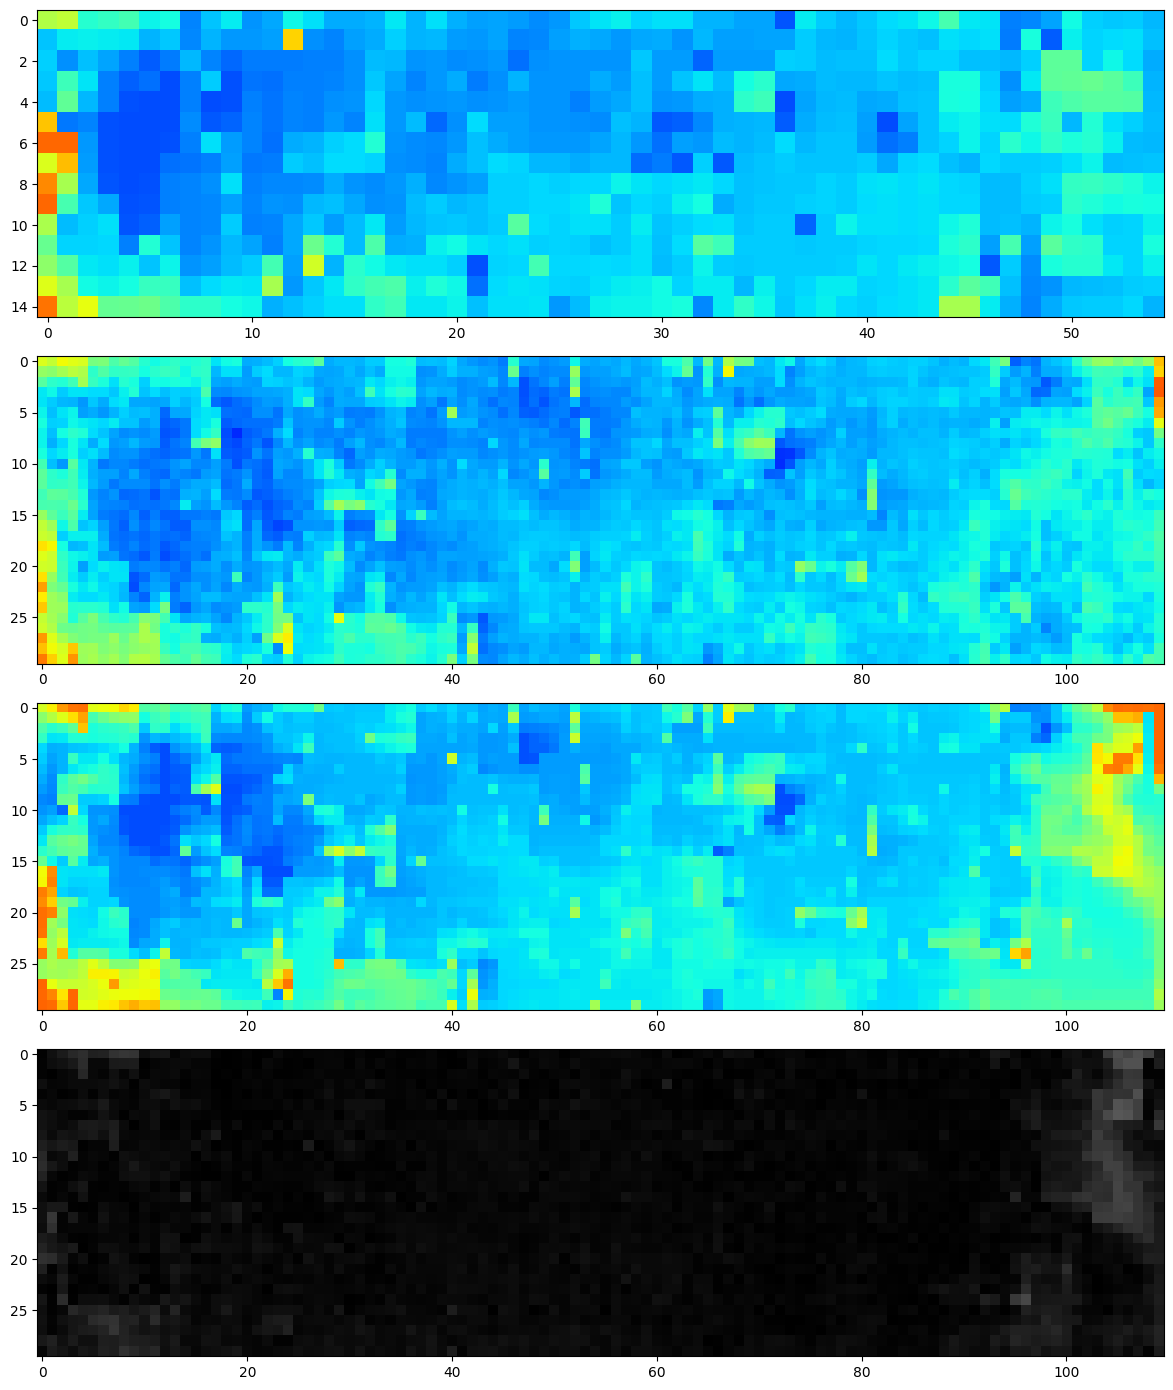

0.3411764705882353


In [11]:
sid = 22
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np

array_lr = np.array(Image.open(f"/media/kimsk/DATA/Nandita_Data/super-resolution/SRGAN-PyTorch/tests/lr_im{sid}.npy.png"))
array_sr = np.array(Image.open(f"/media/kimsk/DATA/Nandita_Data/super-resolution/SRGAN-PyTorch/tests/sr_im{sid}.npy.png"))
array_hr = np.array(Image.open(f"/media/kimsk/DATA/Nandita_Data/super-resolution/SRGAN-PyTorch/tests/hr_im{sid}.npy.png"))

print(np.max(array_lr))

#figure(figsize=(8, 24), dpi=100)
fig, axs = plt.subplots(4,figsize=(16,14), dpi=100)
fig.tight_layout()
axs[0].imshow(array_lr[:,:,0],cmap='jet',vmin=0,vmax=255)
#plt.tight_layout()
#plt.savefig("lr.png")
#plt.show()

#figure(figsize=(8, 6), dpi=100)
axs[1].imshow(np.sum(array_sr[:,:,:],axis=2)/3.0,cmap='jet',vmin=0,vmax=255)
# plt.tight_layout()
# plt.savefig("sr.png")
# plt.show()

#figure(figsize=(8, 6), dpi=100)
axs[2].imshow(array_hr[:,:,0],cmap='jet',vmin=0,vmax=255)
# plt.tight_layout()
# plt.savefig("hr.png")
# plt.show()

# input_X = array_lr[:,:,0].reshape((1,1,array_lr.shape[0],array_lr.shape[1]))
# model_input_X = np.repeat(input_X, 2, axis=2).repeat(2, axis=3)/255.0
# p_highres = (net(torch.Tensor(model_input_X).to(device))).detach().cpu().numpy()
# axs[3].imshow(p_highres[0,0,:,:],cmap='jet',vmin=0,vmax=1)

# figure(figsize=(8, 6), dpi=100)
axs[3].imshow(np.abs(np.sum(array_sr[:,:,:],axis=2)/3.0-array_hr[:,:,0]),cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.savefig("diff.png")
plt.show()

print(np.max(np.abs(np.sum(array_sr[:,:,:],axis=2)/3.0-array_hr[:,:,0]))/255.0)

In [2]:
from skimage.transform import resize

ModuleNotFoundError: No module named 'skimage'

In [12]:
np.save('sat_prof_um.npy',test_array_X[1024:1030,0,:,:])